# [Detekcja pojazdów](https://www.kaggle.com/datasets/ashfakyeafi/road-vehicle-images-dataset)
Użyteczne linki:  
[Exploring your image datasets the right way](https://raychunyin00.medium.com/computer-vision-exploring-your-image-datasets-the-right-way-538c5ae8ca5d)


# Opis problemu i danych
Problem - detekcja i klasyfikacja pojazdów na obrazie  
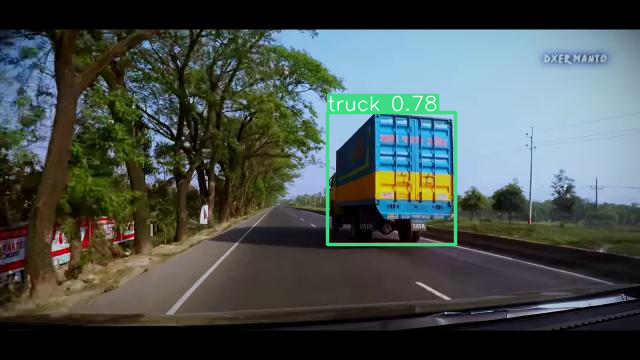

Problem identyfikacji i klasyfikacji obiektu zostaje sprowadzony do problemu klasy regresji poprzez użycie technik YOLO. Połączenia Algorytm YOLO próbuje przeformułować wykrywanie obiektów w pojedynczy problem regresji, łącznie z pikselami obrazu, na prawdopodobieństwa klas i współrzędne ramki ograniczającej. Dlatego algorytm musi spojrzeć na obraz tylko raz, aby przewidzieć i zlokalizować obiekty docelowe na obrazach. 

In [1]:
import os
import random

import cv2

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from typing import List, Tuple
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
#user = "michal"
user = "albert"

if user == "michal":
    train_images = "archive/trafic_data/train/images"
    train_labels = "archive/trafic_data/train/labels"

    valid_images = "archive/trafic_data/valid/images"
    valid_labels = "archive/trafic_data/valid/labels"

elif user == "albert":
    train_images = r"D:\vehicle_detection\trafic_data\train\images"
    train_labels = r"D:\vehicle_detection\trafic_data\train\labels"

    valid_images = r"D:\vehicle_detection\trafic_data\valid\images"
    valid_labels = r"D:\vehicle_detection\trafic_data\valid\labels"



## Wizualizacja danych treningowych - *zdjęć z labelami*

['10 0.07222222222222222 0.4265625 0.14444444444444443 0.128125', '14 0.6111111111111112 0.3890625 0.03611111111111111 0.0421875', '5 0.6333333333333333 0.378125 0.03888888888888889 0.0203125', '19 0.6944444444444444 0.3765625 0.027777777777777776 0.0171875']
['5 0.4265625 0.5987394957983193 0.059375 0.06092436974789916', '18 0.5765625 0.5609243697478992 0.0828125 0.13025210084033614', '18 0.5203125 0.5504201680672269 0.028125 0.10084033613445378', '18 0.4234375 0.5546218487394958 0.025 0.03361344537815126', '18 0.3765625 0.5651260504201681 0.0265625 0.03991596638655462', '9 0.31875 0.5756302521008403 0.0453125 0.025210084033613446', '13 0.25625 0.5966386554621849 0.028125 0.052521008403361345', '18 0.178125 0.5903361344537815 0.078125 0.07773109243697479', '13 0.9203125 0.6029411764705882 0.0515625 0.09033613445378151', '13 0.975 0.6050420168067226 0.040625 0.08403361344537816']
['5 0.3171875 0.8388888888888889 0.390625 0.30833333333333335', '4 0.1828125 0.6222222222222222 0.3390625 0

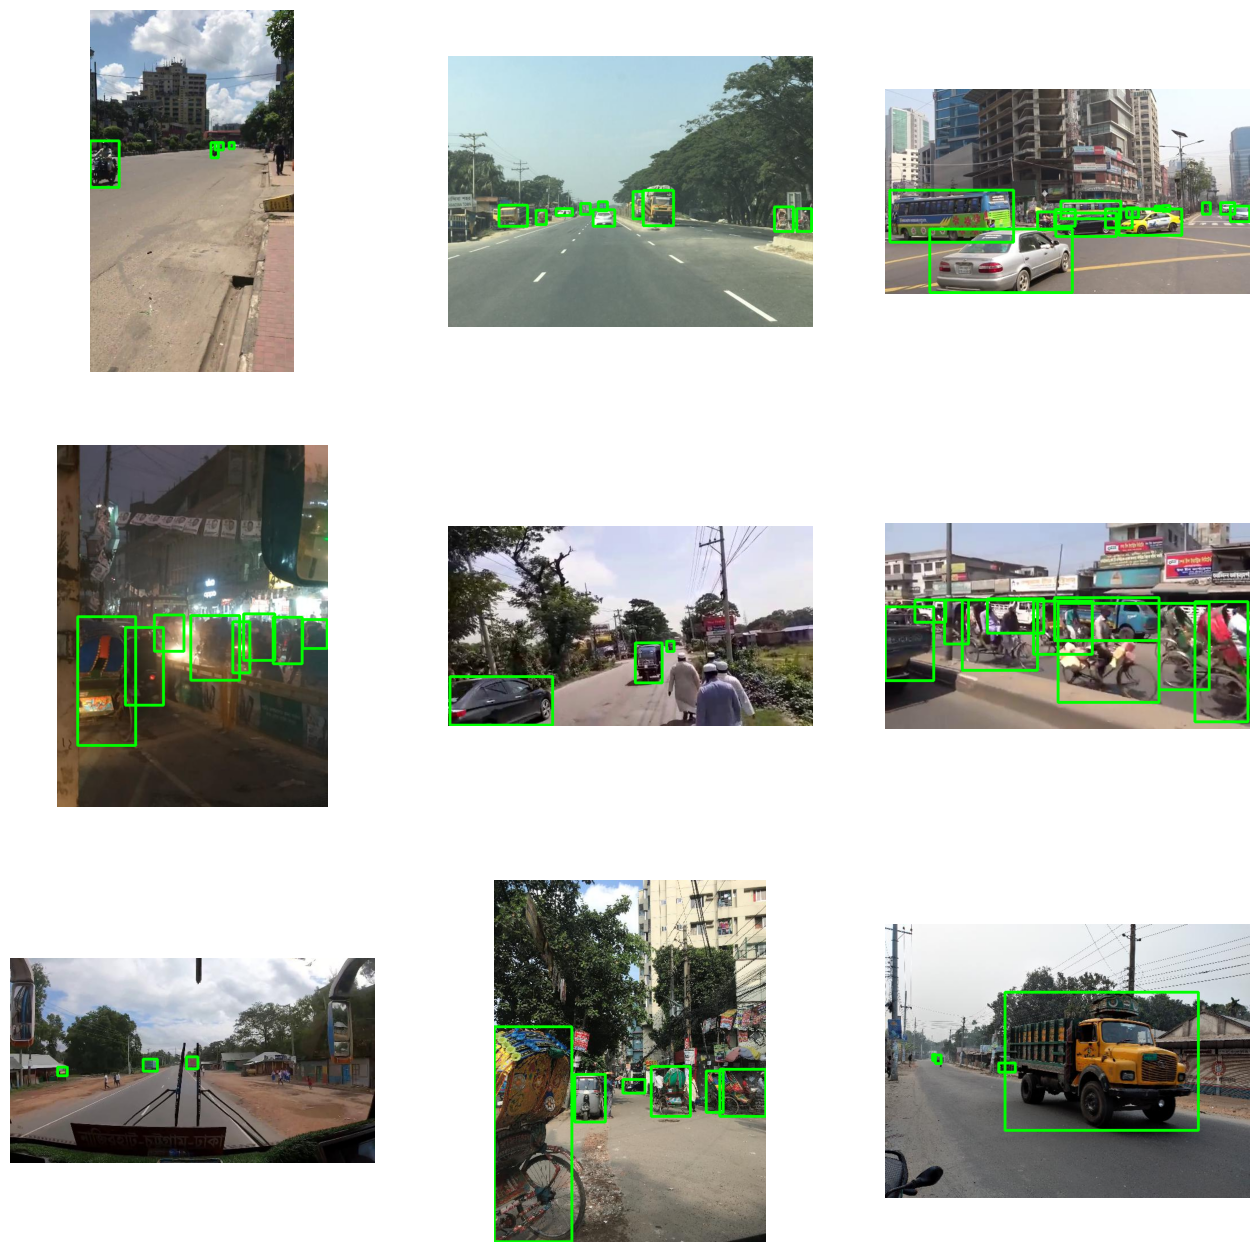

In [3]:
def load_labels(image_file, train_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
    
    return labels



def plot_object_detections(ax, image, labels):
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')



image_files = os.listdir(train_images)
image_files_valid = os.listdir(valid_images)

random_images = random.sample(image_files, 9)

#print(image_files)


fig, axs = plt.subplots(3, 3, figsize=(16, 16))


for i, image_file in enumerate(random_images):
    row, col = divmod(i, 3)
    
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    labels = load_labels(image_file, train_labels)
    print(labels)
    plot_object_detections(axs[row, col], image, labels)

plt.show()

In [4]:
if user == "michal":
    with open('archive/trafic_data/data_1.yaml', 'r') as f:
        data = f.read()
        
elif user == "albert":
    with open(r"D:\vehicle_detection\trafic_data\data_1.yaml", 'r') as f:
        data = f.read()
          
print(data)

train: ../train/images
val: ../valid/images

nc: 21
names: ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers -CNG-', 'truck', 'van', 'wheelbarrow']


In [5]:
h, w, c = image.shape 
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 640x480 and 3 channels.


In [6]:
print(f"Długość zbioru train: {len(image_files)}")
print(f"Długość zbioru valid: {len(image_files_valid)}")
print(f"% Valid: {len(image_files_valid) * 100 / (len(image_files_valid) + len(image_files))}")

Długość zbioru train: 2704
Długość zbioru valid: 300
% Valid: 9.986684420772304


In [7]:
shapes_df_train = pd.DataFrame()
heights = []
widths = []
channels = []
for i, image_file in enumerate(image_files):
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)
    
    shape = image.shape
    heights.append(shape[0])
    widths.append(shape[1])
    channels.append(shape[2])

shapes_df_train['width'] = widths
shapes_df_train['height'] = heights
shapes_df_train['channel'] = channels

shapes_df_valid =  pd.DataFrame()
heights = []
widths = []
channels = []
for i, image_file in enumerate(image_files_valid):
    image_path = os.path.join(valid_images, image_file)
    image = cv2.imread(image_path)
    
    shape = image.shape
    heights.append(shape[0])
    widths.append(shape[1])
    channels.append(shape[2])

shapes_df_valid['width'] = widths
shapes_df_valid['height'] = heights
shapes_df_valid['channel'] = channels

In [8]:
print(f"""Unique (Width, Height, Channel) values for train data: {
    len(shapes_df_train['width'].unique()),
    len(shapes_df_train['height'].unique()),
    len(shapes_df_train['channel'].unique())
    }""")

print(f"""Unique (Width, Height, Channel) values for valid data: {
    len(shapes_df_valid['width'].unique()),
    len(shapes_df_valid['height'].unique()),
    len(shapes_df_valid['channel'].unique())
    }""")

Unique (Width, Height, Channel) values for train data: (73, 200, 1)
Unique (Width, Height, Channel) values for valid data: (2, 4, 1)


In [9]:
print(f"""Unikalne kombinacje train: {
    len(shapes_df_train[['width', 'height', 'channel']].drop_duplicates())
    }""")

print(f"""Unikalne kombinacje valid: {
    len(shapes_df_valid[['width', 'height', 'channel']].drop_duplicates())
    }""")

Unikalne kombinacje train: 270
Unikalne kombinacje valid: 4


In [10]:
print('train images')
print(shapes_df_train.value_counts()[:5])


print('valid images')
print(shapes_df_valid.value_counts()[:5])

train images
width  height  channel
640    360     3          1510
360    640     3           274
480    640     3           138
640    359     3           132
       362     3            85
Name: count, dtype: int64
valid images
width  height  channel
640    360     3          162
       359     3          136
1125   614     3            1
       621     3            1
Name: count, dtype: int64


Widać, że najpopularniejsza kombinacja to 640x360 i vice versa.

In [11]:
# treating WxH as HxW
most_popular_shape = shapes_df_train.value_counts()[:2]
print(f"% zbioru jaki ma najpopularniejsza ({most_popular_shape[:1].index.names}) rozdzielczość: {most_popular_shape.sum()/len(shapes_df_train)*100:.2f} %")

most_popular_shape = shapes_df_valid.value_counts()[:2]
print(f"% zbioru jaki ma najpopularniejsza ({most_popular_shape[:1].index.names}) rozdzielczość: {most_popular_shape.sum()/len(shapes_df_valid)*100:.2f} %")

% zbioru jaki ma najpopularniejsza (['width', 'height', 'channel']) rozdzielczość: 65.98 %
% zbioru jaki ma najpopularniejsza (['width', 'height', 'channel']) rozdzielczość: 99.33 %


In [12]:
del shapes_df_train
del shapes_df_valid

In [13]:
def files_to_df(files,images):

    mean_r_values = []
    mean_g_values = []
    mean_b_values = []
    mean_values = []
    for i, image_file in enumerate(files):
        image_path = os.path.join(images, image_file)
        image = cv2.imread(image_path)

        mean_r_value = np.mean(image[:, :, 0])
        mean_r_values.append(mean_r_value)

        mean_g_value = np.mean(image[:, :, 1])
        mean_g_values.append(mean_g_value)

        mean_b_value = np.mean(image[:, :, 2])
        mean_b_values.append(mean_b_value)

        mean_value = np.mean(image)
        mean_values.append(mean_value)
        
    df = pd.DataFrame()
    df['r_mean'] = mean_r_values
    df['g_mean'] = mean_g_values
    df['b_mean'] = mean_b_values

    return df

In [14]:
def normalization_tests(color_df):

    stat, p = shapiro(color_df)
    print(f"Shapiro-Wilk score: {stat}, p-value: {p}")

    stat, p = kstest(color_df["r_mean"],"norm")
    print(f"Kolmogorow-Smirnow score for r_mean: {stat}, p-value: {p}")


    stat, p = kstest(color_df["g_mean"],"norm")
    print(f"Kolmogorow-Smirnow score for g_mean: {stat}, p-value: {p}")


    stat, p = kstest(color_df["b_mean"],"norm")
    print(f"Kolmogorow-Smirnow score for b_mean: {stat}, p-value: {p}")

In [15]:
def plot_colors(files,images):

    color_df = files_to_df(files,images)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    plt.rcParams['lines.linewidth'] = 0.5

    sns.kdeplot(color_df['r_mean'], color='r', fill=True, label=f'Red Mean = {np.mean(color_df.r_mean):.1f}')
    sns.kdeplot(color_df['g_mean'], color='g', fill=True, label=f'Green Mean = {np.mean(color_df.g_mean):.1f}')
    sns.kdeplot(color_df['b_mean'], color='b', fill=True, label=f'Blue Mean = {np.mean(color_df.b_mean):.1f}')

    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.legend()
    plt.show()


    color_df.describe()

    normalization_tests(color_df)

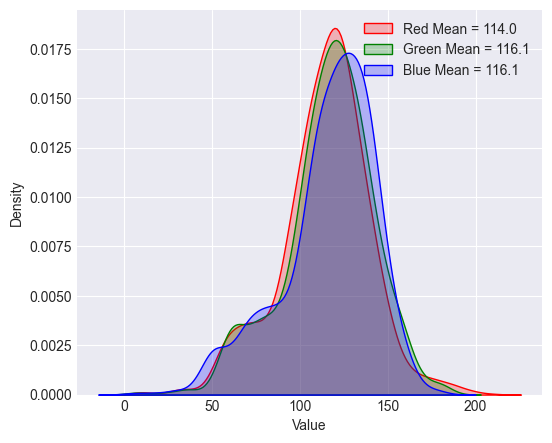

C:\Users\adank\AppData\Local\Temp\ipykernel_7532\1498151782.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8112.
  stat, p = shapiro(color_df)


Shapiro-Wilk score: 0.9743929787723786, p-value: 1.0075286838187742e-35
Kolmogorow-Smirnow score for r_mean: 0.9999999999984994, p-value: 0.0
Kolmogorow-Smirnow score for g_mean: 0.9996301699976553, p-value: 0.0
Kolmogorow-Smirnow score for b_mean: 0.9996293972858735, p-value: 0.0


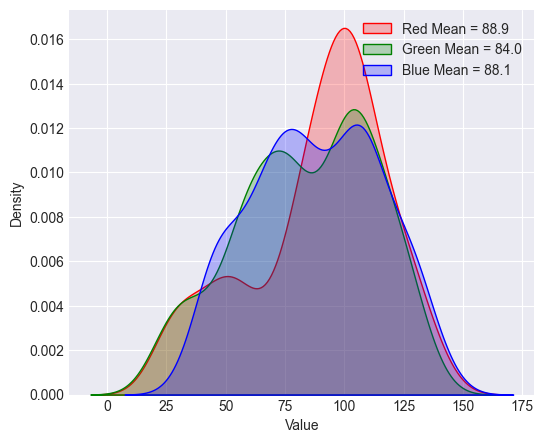

Shapiro-Wilk score: 0.9746267260271092, p-value: 2.0518171613754277e-11
Kolmogorow-Smirnow score for r_mean: 1.0, p-value: 0.0
Kolmogorow-Smirnow score for g_mean: 1.0, p-value: 0.0
Kolmogorow-Smirnow score for b_mean: 1.0, p-value: 0.0


In [16]:
plot_colors(image_files,train_images)
plot_colors(image_files_valid,valid_images)

Jak widać na powyższym wykresie i statystykach, rozkład kolorów jest podobny oraz w miarę zrównoważony. Widać także, że średnia kolorów jest raczej poniżej spodziewanej średniej standardowego rozkładu kolorów (średnia 128). Natomiast test Shapiro-Wilka na normalizację wskazuje wysoki wynik z niezwykle niskim p-value, co oznacza, że wynik ma bardzo niskie prawdopodobieństwo bycia przypadkiem. Zatem można obyć się bez normalizacji.

Ostrzeżenie, które pojawia się podczas uruchamiania testu Shapiro-Wilka wskazuje na to, że mogą pojawiać się pewne niedokładności z powodu przeznaczenia tego testu głównie dla małych prób. Progiem istotności jest p=0.05, nasz wynik jest nieporównywalnie mniejszy, natomiast wykonaliśmy jeszcze test Kolmogorowa-Smirnowa, który powinien zwracać dokładniejszy wynik dla tak dużych prób, jak ta. Wyniki są jeszcze badziej zbliżone do idealnych, stąd odrzucamy istotność testu, czyli hipotezę zerową dla rozkładu normalnego. 

Histogram dla zmiennej wyjściowej:


In [17]:
if user == "michal":
    with open('archive/trafic_data/data_1.yaml', 'r') as f:
        data = f.readlines()
    
elif user == "albert":
    with open(r"D:\vehicle_detection\trafic_data\data_1.yaml", 'r') as f:
        data = f.readlines()


vehicles_str = data[4].split(": ")[1].replace("[","").replace("]","")
vehicles_str = list(vehicles_str.split(", "))

classes_of_vehicles = []

for vehicle in vehicles_str:

    vehicle = vehicle.replace("'","")
    classes_of_vehicles.append(vehicle)


In [18]:
vehicles_counter = [0] * len(classes_of_vehicles)

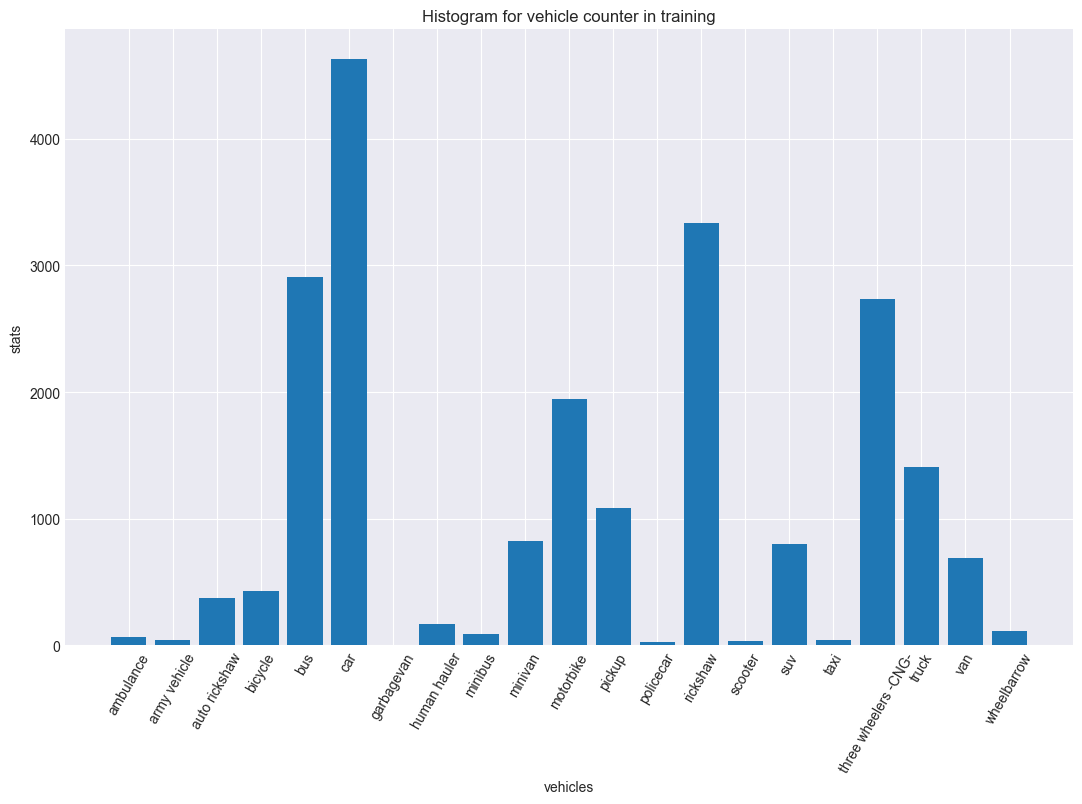

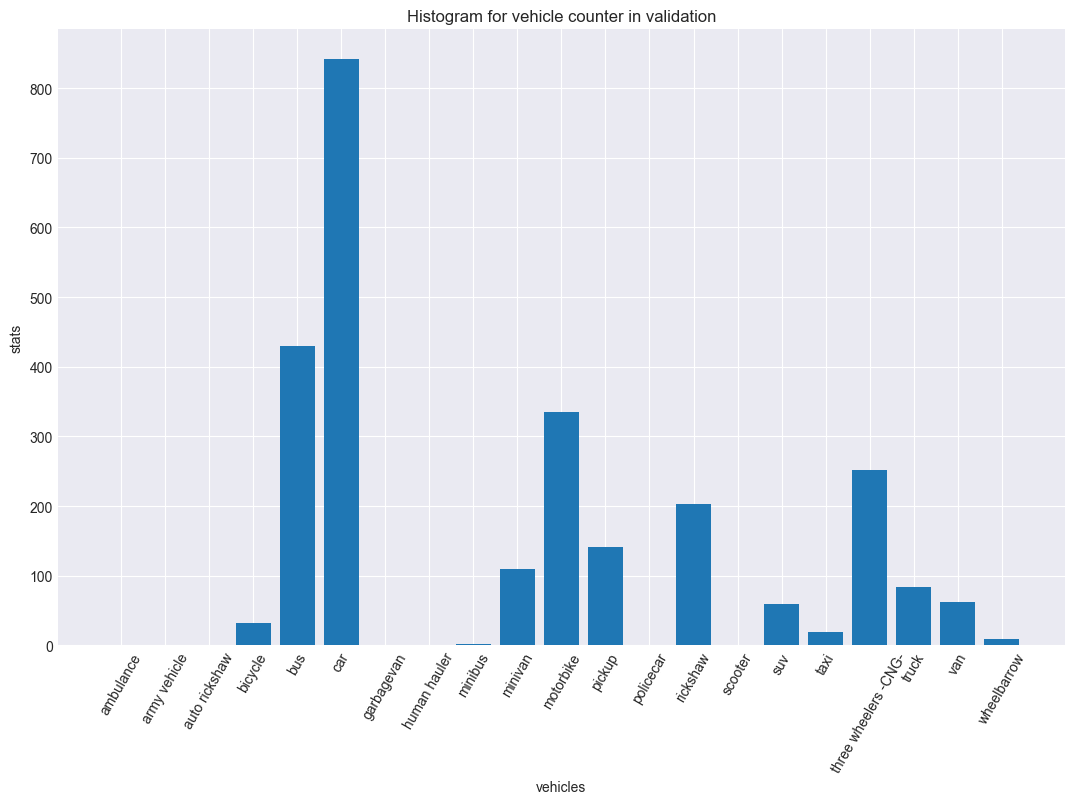

In [19]:
train_vehicles_counter = [0] * len(classes_of_vehicles)
valid_vehicles_counter = [0] * len(classes_of_vehicles)

for i, image_file in enumerate(image_files):


    labels = load_labels(image_file, train_labels)
    
    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                train_vehicles_counter[vehicle_nr] += 1

# print(train_vehicles_counter)
# print(classes_of_vehicles)

plt.figure(figsize=(13, 8))
plt.bar(classes_of_vehicles, train_vehicles_counter)
plt.title('Histogram for vehicle counter in training', fontsize=12)
plt.xlabel('vehicles', fontsize=10)
plt.ylabel('stats', fontsize=10)
plt.xticks(fontsize=10,rotation=60)
plt.yticks(fontsize=10)
plt.show()


for i, image_file in enumerate(image_files_valid):

    labels = load_labels(image_file, valid_labels)
    
    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                valid_vehicles_counter[vehicle_nr] += 1



plt.figure(figsize=(13, 8))
plt.bar(classes_of_vehicles, valid_vehicles_counter)
plt.title('Histogram for vehicle counter in validation', fontsize=12)
plt.xlabel('vehicles', fontsize=10)
plt.ylabel('stats', fontsize=10)
plt.xticks(fontsize=10,rotation=60)
plt.yticks(fontsize=10)
plt.show()

In [20]:
def accumulate_results(_list: List[Tuple[any, any]], threshold: int):
    other_count = 0
    other_classes_count = 0
    for i, (count, class_name) in enumerate(_list):
        if count < threshold:
            _list[i] = (count, 'other')
            other_count += count
            other_classes_count+=1
        else:
            break

    if other_count > 0:
        _list = [(other_count, f'other ({other_classes_count} classes)')] + _list[i:]
    
    return zip(*_list)

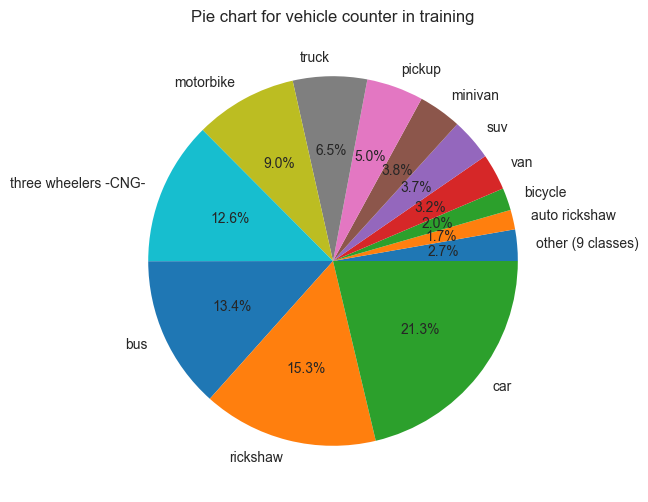

In [21]:
sorted_vehicles = sorted(list(zip(train_vehicles_counter, classes_of_vehicles)), key=lambda x: x[0])

sorted_train_vehicles_counter, sorted_classes_of_vehicles = accumulate_results(sorted_vehicles, 200)

plt.figure(figsize=(6, 6))
plt.pie(sorted_train_vehicles_counter, labels=sorted_classes_of_vehicles, autopct='%1.1f%%')
plt.title('Pie chart for vehicle counter in training', fontsize=12)
plt.xticks(fontsize=10,rotation=60)
plt.yticks(fontsize=10)
plt.show()

In [22]:
print(f"Udział pierwszych 4 klas: {sum(sorted_train_vehicles_counter[-4:]) *100 / sum(sorted_train_vehicles_counter):.2f}")
print(f"Udział pierwszych 9 klas: {sum(sorted_train_vehicles_counter[-9:]) *100 / sum(sorted_train_vehicles_counter):.2f}")

Udział pierwszych 4 klas: 62.54
Udział pierwszych 9 klas: 90.40


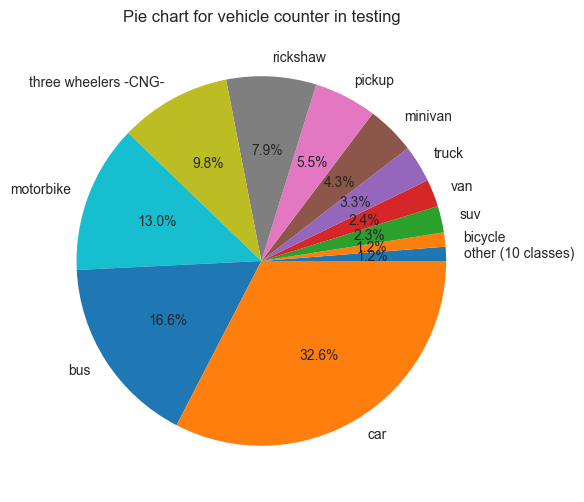

In [23]:
sorted_vehicles = sorted(list(zip(valid_vehicles_counter, classes_of_vehicles)), key=lambda x: x[0])

sorted_valid_vehicles_counter, sorted_classes_of_vehicles = accumulate_results(sorted_vehicles, 20)

plt.figure(figsize=(6, 6))
plt.pie(sorted_valid_vehicles_counter, labels=sorted_classes_of_vehicles, autopct='%1.1f%%')
plt.title('Pie chart for vehicle counter in testing', fontsize=12)
plt.xticks(fontsize=10,rotation=60)
plt.yticks(fontsize=10)
plt.show()

## Ustalenie Udziału procentowego klas w zbiorach treningowym i walidacyjnym (testowym)

In [49]:
all_vehicles_counter = [x[0] + x[1] for x in zip(train_vehicles_counter, valid_vehicles_counter)]
train_vehicles_percentage = [x[0]*100/x[1] for x in zip(train_vehicles_counter, all_vehicles_counter)]
valid_vehicles_percentage = [x[0]*100/x[1] for x in zip(valid_vehicles_counter, all_vehicles_counter)]

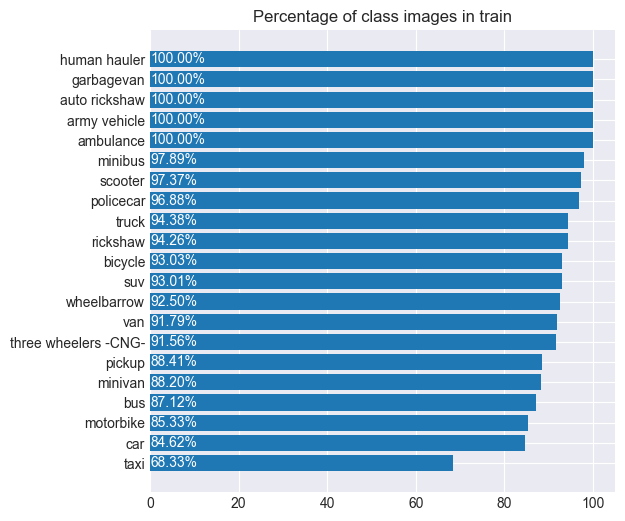

In [50]:
sorted_vehicles = sorted(list(zip(train_vehicles_percentage, classes_of_vehicles)), key=lambda x: x[0])

sorted_train_vehicles_percentage, sorted_classes_of_vehicles = accumulate_results(sorted_vehicles, 5)

plt.figure(figsize=(6, 6))
plt.barh(sorted_classes_of_vehicles, sorted_train_vehicles_percentage)

for i, v in enumerate(sorted_train_vehicles_percentage):
    plt.annotate(f"{v:.2f}%", xy=(0, i), color='w', va='center')
    
plt.title('Percentage of class images in train', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Powyższy wykres można zinterpretować także słownie: jaki procent klas znajduje się w zbiorze treningowym (w przeciwieństwie do testowego)

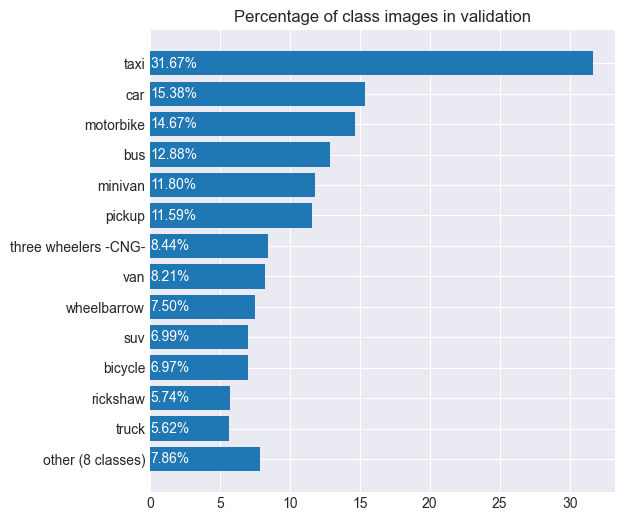

In [51]:
sorted_vehicles = sorted(list(zip(valid_vehicles_percentage, classes_of_vehicles)), key=lambda x: x[0])

sorted_valid_vehicles_percentage, sorted_classes_of_vehicles = accumulate_results(sorted_vehicles, 5)

plt.figure(figsize=(6, 6))
plt.barh(sorted_classes_of_vehicles, sorted_valid_vehicles_percentage)

for i, v in enumerate(sorted_valid_vehicles_percentage):
    plt.annotate(f"{v:.2f}%", xy=(0, i), color='w', va='center')
    
plt.title('Percentage of class images in validation', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Podsumowanie sekcji
- 21 klas
- zbiór posiada 2704 obrazy
- istnieje wiele unikalnych wartości wysokości i szerokości obrazów, natomiast wartość kanałów jest jedna: 3 (RGB).
- unikalnych kombinacji tych trzech parametrów jest 270.  
- najpopularniejsza z nich (640x360 i odwrotnie) to około 66% całego zbioru. podczas transformacji warto będzie się przyglądnąć temu rozkładowi.

Oznacza to, że model albo musi być uniwersalny w przyjmowaniu rozmiarów wejściowych, albo obrazy należy zmodyfikować (a tym samym zmienić proporcje z np. 16:9 -> 1:1 {ustalona wielkość})  
Jedyne dane jakie posiadamy w tej chwili to dane zdjęcia, czyli zmienne traktowane ilościowo.  
  
Przeglądając te zdjęcia można zauważyć, że są one prawdopodobnie wyłącznie w jednym kraju, zapewne Azjatyckim. (Mój typ: Indie lub Tajlandia).

Rozkład kolorów na zdjęciu jest zrównoważony i bardzo zbliżony do rozkładu normalnego, jak to ukazazał nam test Shapiro-Wilka (0.97 z p-value 10^(-35)) oraz Kołmogorowa-Smirnowa, zatem nie jest konieczna normalizacja.

Problematyczne są niezbalansowane klasy. Zdecydowanie jest najwięcej samochodów, następnie w podobnych ilościach są riksze, busy oraz trójkołowce (zmotoryzowane riksze na gaz). Potem stopniowo co raz mniej znaczące są klasy.

Cztery największe klasy - Samochody, busy i riksze ( + zmotoryzowane) na tych obecnych zdjęciach zajmują ponad 62,5% zbioru.  
Natomiast 9 największych klas to ponad 90% wszystkich klas. Na późniejszych etapach konieczne będzie wzięcie tego faktu pod uwagę

# Obróbka danych

Co należy zrobić:  

Wyznaczony zbiór danych jest niedoreprezentowany. Jak widać na histogramie danych walidacyjnych, 7 zmiennych nie ma ani jednego przykładu testowego. Konieczne jest zrebalansowanie obecnego stanu rzeczy.

In [132]:
# collect data into single dataframe

all_images = []
all_images.extend(image_files)
all_images.extend(image_files_valid)

all_images_directory = []
all_images_directory.extend([train_images for img in image_files])
all_images_directory.extend([valid_images for img in image_files_valid])

all_images_label_directory = []
all_images_label_directory.extend([train_labels for img in image_files])
all_images_label_directory.extend([valid_labels for img in image_files_valid])

In [133]:
# df will be two datasets connected in single

df = pd.DataFrame()
df['directory'] = all_images_directory
df['label_directory'] = all_images_label_directory
df['image'] = all_images

In [134]:
df.head()

,directory,label_directory,image
0,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,01_jpg.rf.8d8a2f0f90d5b83893cd252acd832c93.jpg
1,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,02_jpg.rf.65a084066fc353cd023eb5c953f40efe.jpg
2,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,03_jpg.rf.4532f2db68433995da09f54e215160f3.jpg
3,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,04_jpg.rf.c0b83432c4d09c7cbeaac18e14c4a54a.jpg
4,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,05_jpg.rf.11a2e7ce391a1e74960099f7923f27f5.jpg


Train image:


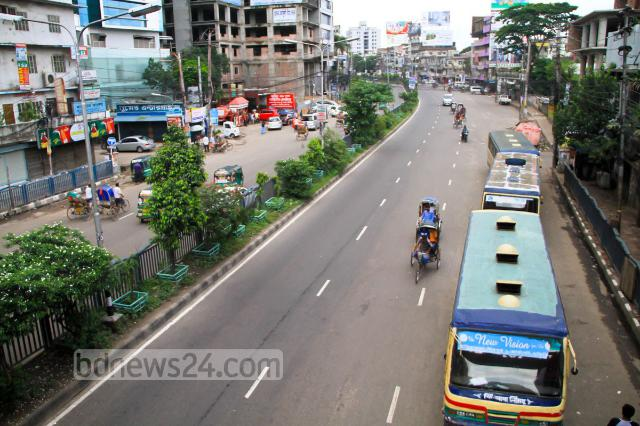

In [135]:
print("Train image:")
Image.open(os.path.join(all_images_directory[0], all_images[0]))

Test image:


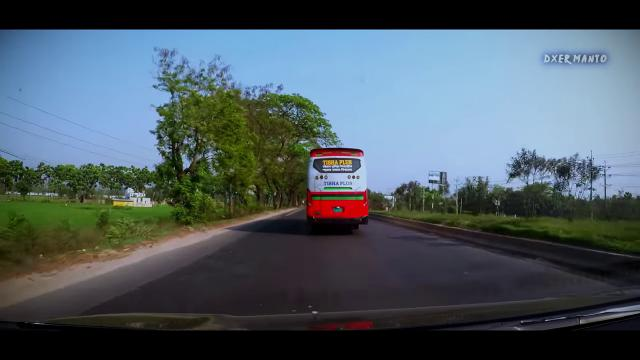

In [136]:
print("Test image:")
Image.open(os.path.join(all_images_directory[-1], all_images[-1]))

Poprzedni podział na dane treningowe i testowe uznajemy za nieważny i będziemy w przyszłości mieszać te dane w celu uzyskania lepszych rezultatów statystycznych. 

Dodajemy dane klasyfikacyjne do nowego zbioru danych:

In [137]:
classes = []

for i, row in df.iterrows():
    labels = load_labels(row['image'], row['label_directory'])
    image_classes = []
    
    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                image_classes.append(vehicle_nr)
    classes.append(image_classes)
    
df['classes'] = classes

In [138]:
df

,directory,label_directory,image,classes
0,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,01_jpg.rf.8d8a2f0f90d5b83893cd252acd832c93.jpg,[]
1,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,02_jpg.rf.65a084066fc353cd023eb5c953f40efe.jpg,"[17, 19, 17, 10, 10, 10, 10, 10, 10, 10, 16, 1..."
2,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,03_jpg.rf.4532f2db68433995da09f54e215160f3.jpg,"[18, 4, 13, 18, 10]"
3,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,04_jpg.rf.c0b83432c4d09c7cbeaac18e14c4a54a.jpg,"[11, 13, 4, 15, 5, 10, 4, 4, 4, 4, 4, 11, 4, 4..."
4,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,05_jpg.rf.11a2e7ce391a1e74960099f7923f27f5.jpg,"[5, 5, 17, 3, 15, 13, 5, 5, 10, 5, 5, 5, 19, 1..."
...,...,...,...,...
2999,D:\vehicle_detection\trafic_data\valid\images,D:\vehicle_detection\trafic_data\valid\labels,Pias--404-_jpg.rf.fbdfbf989b0393f8b53767bf1931...,"[4, 18]"
3000,D:\vehicle_detection\trafic_data\valid\images,D:\vehicle_detection\trafic_data\valid\labels,Pias--405-_jpg.rf.32ec5a12516f420a383a4807a9c6...,"[18, 18, 4]"
3001,D:\vehicle_detection\trafic_data\valid\images,D:\vehicle_detection\trafic_data\valid\labels,Pias--406-_jpg.rf.81e211763107ba138599adcf13f8...,"[4, 18]"
3002,D:\vehicle_detection\trafic_data\valid\images,D:\vehicle_detection\trafic_data\valid\labels,Pias--407-_jpg.rf.ed2b7fe618a64b4423419620ebbb...,[4]


In [139]:
# mix dataframe to split it once again to train, valid, test 

df_base_resampled = df.sample(frac=1).reset_index(drop=True)
df_base_resampled


,directory,label_directory,image,classes
0,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Navid_307_jpg.rf.974986c43344943d76616c03deb23...,"[4, 5, 4, 19, 9]"
1,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Navid_62_jpg.rf.581fc88367d10ad9ee22336659c4ca...,"[13, 13, 13, 4, 10]"
2,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Dipto_453_jpg.rf.1dd86d96dcd4765bbbe5563a8eae6...,"[4, 18, 18, 11]"
3,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Numan_-236-_jpg.rf.192ab232373daca17779221395f...,"[18, 18, 4, 4]"
4,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Navid_175_jpg.rf.d79a00a2340d858ca808c1bdb1a82...,"[11, 18, 11]"
...,...,...,...,...
2999,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Navid_655_JPG.rf.6272fb6a7e23e9bb10ebc97ce837e...,"[10, 10]"
3000,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Numan_-70-_jpg.rf.1e19e15097e0e4916e84de0c8cbc...,"[3, 5, 5, 4, 13, 13, 13, 10, 4, 10, 13, 17, 10..."
3001,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,60_jpg.rf.3c041ee2d63dd927ef9236ab5807a450.jpg,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
3002,D:\vehicle_detection\trafic_data\train\images,D:\vehicle_detection\trafic_data\train\labels,Navid_779_jpg.rf.a62a3b4365174949df97d1e885737...,"[13, 20, 13, 13, 17, 17, 17, 17, 17, 10]"


In [140]:

# split into 3 dataframes including training, validation , testing
 

split_ratio = (0.7, 0.1, 0.2)

split_index1 = int(split_ratio[0]*len(df_base_resampled))
split_index2 = int((split_ratio[0]+split_ratio[1])*len(df_base_resampled))
df_training = df_base_resampled[:split_index1]
df_validation = df_base_resampled[split_index1:split_index2]
df_testing = df_base_resampled[split_index2:]

print(f"Training DataFrame size: {len(df_training)}")
print(f"Validation DataFrame size: {len(df_validation)}")
print(f"Testing DataFrame size: {len(df_testing)}")


Training DataFrame size: 2102
Validation DataFrame size: 301
Testing DataFrame size: 601


In [141]:
train_vehicles_counter = [0] * len(classes_of_vehicles)
valid_vehicles_counter = [0] * len(classes_of_vehicles)
test_vehicles_counter = [0] * len(classes_of_vehicles)



for i, row in df_training.iterrows():
    labels = load_labels(row['image'], row['label_directory'])
    
    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                train_vehicles_counter[vehicle_nr] += 1



for i, row in df_validation.iterrows():
    labels = load_labels(row['image'], row['label_directory'])

    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                valid_vehicles_counter[vehicle_nr] += 1



for i, row in df_testing.iterrows():
    labels = load_labels(row['image'], row['label_directory'])
    
    for label in labels:
        if label.split(" ")[0] != '':
            
            vehicle_nr = int(label.split(" ")[0])

            if vehicle_nr >= 0 and vehicle_nr < len(classes_of_vehicles):
                test_vehicles_counter[vehicle_nr] += 1

In [142]:
from scipy.stats import chi2_contingency

# Create a contingency table of %
contingency_table = [[val / sum(train_vehicles_counter) for val in train_vehicles_counter], 
                     [val / sum(valid_vehicles_counter) for val in valid_vehicles_counter],
                     [val / sum(test_vehicles_counter) for val in test_vehicles_counter]]
# contingency_table = [ train_vehicles_counter,valid_vehicles_counter,test_vehicles_counter]

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the p-value
print(f'p-value: {p}')


# Interpret the result
if p < 0.05:
    print('The class distributions are significantly different.')
else:
    print('The class distributions are not significantly different.')

p-value: 1.0
The class distributions are not significantly different.


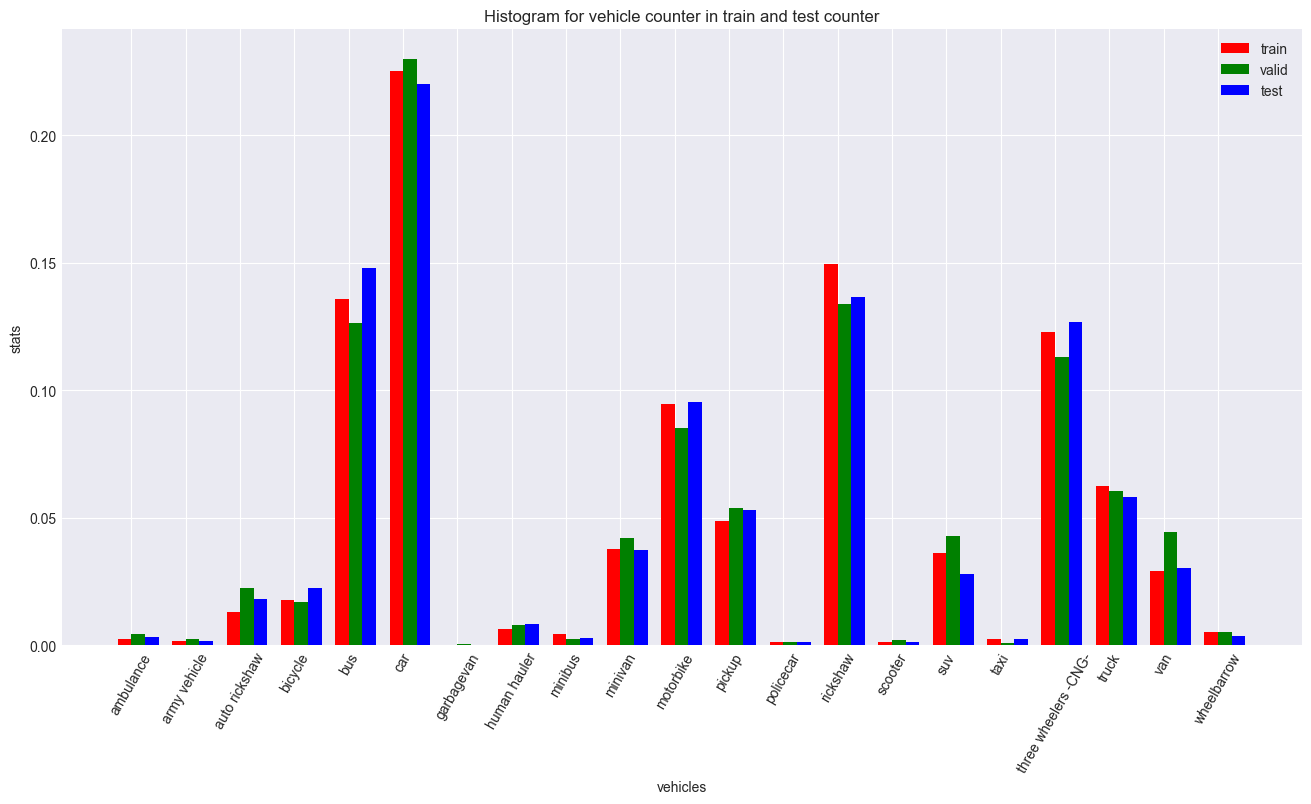

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Define the width of the bars
bar_width = 0.25

# Create the positions of the bars on the x-axis
r1 = np.arange(len(test_vehicles_counter))
r2 = [x + bar_width for x in r1]
r3 = [x + 2*bar_width for x in r1]

plt.figure(figsize=(16, 8))

# Plot the bars
plt.bar(r1, [val / sum(train_vehicles_counter) for val in train_vehicles_counter], color='r', width=bar_width, label='train')
plt.bar(r2, [val / sum(valid_vehicles_counter) for val in valid_vehicles_counter], color='g', width=bar_width, label='valid')
plt.bar(r3, [val / sum(test_vehicles_counter) for val in test_vehicles_counter], color='b', width=bar_width, label='test')



# Add xticks in the middle of the two bars
plt.xlabel('vehicles', fontsize=10)
plt.ylabel('stats', fontsize=10)
plt.xticks([r + bar_width / 2 for r in range(len(test_vehicles_counter))], classes_of_vehicles, fontsize=10, rotation=60)
plt.yticks(fontsize=10)

plt.title("Histogram for vehicle counter in train and test counter")
plt.legend()
plt.show()

In [144]:
print(f"% Train: {(len(df_training) * 100 / 3004):.3f}")
print(f"% Valid: {(len(df_validation) * 100 / 3004):.3f}")
print(f"% Test: {(len(df_testing) * 100 / 3004):.3f}")

% Train: 69.973
% Valid: 10.020
% Test: 20.007


# Yolov5 Prediction

In [175]:
import os, sys
import glob
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git
TRAIN = True
EPOCHS = 25

In [165]:
!python -v

^C


In [162]:
print(sys.path)

['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\adank\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\adank\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\adank\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\adank\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_

In [169]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('../trafic_data/runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [166]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir /trafic_data/runs/train

In [161]:
monitor_tensorboard()

In [172]:
!pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.7 kB ? eta -:--:--
   ----------- --------------------------- 41.0/138.7 kB 393.8 kB/s eta 0:00:01
   ------------------------------------ - 133.1/138.7 kB 871.5 kB/s eta 0:00:01
   -------------------------------------- 138.7/138.7 kB 823.3 kB/s eta 0:00:00


In [177]:
RES_DIR = set_res_dir()
if TRAIN:
    !python ./yolov5/train.py --data ../trafic_data/data_1.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1


Traceback (most recent call last):
  File "C:\Users\adank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\git\cmd.py", line 1262, in execute
    proc = safer_popen(
           ^^^^^^^^^^^^
  File "C:\Users\adank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\git\cmd.py", line 281, in _safer_popen_windows
    return Popen(
           ^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFound

In [ ]:
class DetectionDataset(tc.utils.data.Dataset):
    def __init__(self,
                 csv_path,
                 transform=tv.transforms.Compose([tv.transforms.Resize((256,256)),tv.transforms.ToTensor()]),
                 z_norm=False):
        self.csv_path = csv_path
        self.transform = transform
        self.dataframe = list(tuple(line) for line in csv.reader(open(csv_path))) # TODO - read the previously created csv
        self.dataframe = self.dataframe[1:]





    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # TODO - repeat the steps from the previous dataloader

        current_case = self.dataframe[idx]
        current_path_img = current_case[0]
        current_path_mask = current_case[1]

        current_image = Image.open(current_path_img).convert('RGB')

        if self.transform:
            current_image = self.transform(current_image)

        current_image = tc.reshape(current_image, (3,256,256))

        current_mask = Image.open(current_path_mask)
        if self.transform:
            current_mask = self.mask_transform(current_mask)
        current_mask = transform_binary_mask(current_mask)
            

        #current_image = tc.flip(current_image, [0, 1])



        return current_image, current_mask